In [1]:
# %%
import pandas as pd 
# Load preprocessed data
train_df = pd.read_csv("train_data_final_2.csv")
test_df = pd.read_csv("test_data_final_2.csv")

# %%
# Inspect the first few rows
print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())


Training Data:
                                    tokenized_review  label  \
0  ['bromwell', 'high', 'cartoon', 'comedy', 'ran...      1   
1  ['homelessness', 'houselessness', 'george', 'c...      1   
2  ['brilliant', 'overacting', 'lesley', 'ann', '...      1   
3  ['easily', 'underrated', 'film', 'inn', 'brook...      1   
4  ['typical', 'mel', 'brooks', 'film', 'slapstic...      1   

                                       padded_review  
0  [1, 7323, 2274, 2956, 12444, 15823, 12104, 136...  
1  [1, 1, 6465, 1, 14855, 8270, 17417, 11633, 724...  
2  [1864, 11048, 1, 580, 16961, 1411, 4634, 1, 87...  
3  [4836, 16350, 5810, 7999, 1904, 2164, 15282, 5...  
4  [16264, 9793, 1904, 5810, 14290, 10269, 151, 1...  

Test Data:
                                    tokenized_review  label  \
0  ['went', 'saw', 'movie', 'night', 'coaxed', 'f...      1   
1  ['actor', 'turned', 'director', 'bill', 'paxto...      1   
2  ['recreational', 'golfer', 'knowledge', 'sport...      1   
3  ['saw', '

## RNNS

In [ ]:
import torch
import pandas as pd 
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import ast 
from torch.utils.data import DataLoader

class SentimentDataset(Dataset):
    def __init__(self, dataframe, max_length=105, vocab_size=10000):
        self.reviews = dataframe['padded_review']
        self.labels = dataframe['label']
        self.max_length = max_length
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        indices = self.reviews.iloc[idx]
        multi_hot_vector = torch.zeros(self.vocab_size)
        for index in indices:
            if index < self.vocab_size:
                multi_hot_vector[index] = 1
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return multi_hot_vector, label

vocab_size = 17502
max_length = 105
batch_size = 16

train_df = pd.read_csv('train_data_final_2.csv')
train_df = train_df.sample(n=4000, random_state=42)

test_df = pd.read_csv('test_data_final_2.csv')
test_df = test_df.sample(n=300, random_state=42)

train_data, dev_data = train_test_split(train_df, test_size=0.2, random_state=42)
test_data = test_df

max_length = 105  

train_df['padded_review'] = train_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
dev_df = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(dev_df.index)
test_df['padded_review'] = test_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])

train_df['label'] = pd.to_numeric(train_df['label'])
dev_df['label'] = pd.to_numeric(dev_df['label'])
test_df['label'] = pd.to_numeric(test_df['label'])

train_dataset = SentimentDataset(train_df)
dev_dataset = SentimentDataset(dev_df)
test_dataset = SentimentDataset(test_df)

batch_size = 16

train_dataset = SentimentDataset(train_df, max_length=max_length, vocab_size=vocab_size)
dev_dataset = SentimentDataset(dev_df, max_length=max_length, vocab_size=vocab_size)
test_dataset = SentimentDataset(test_df, max_length=max_length, vocab_size=vocab_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in dev loader: {len(dev_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in training loader: 225
Number of batches in dev loader: 25
Number of batches in test loader: 19


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, num_layers=1, dropout=0.5, attention_layers=2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention_layers = attention_layers

        self.lstm = nn.LSTM(
            vocab_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention_stack = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(attention_layers)])
        self.final_attention = nn.Linear(hidden_size, 1)  # Final attention layer for weights
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x.unsqueeze(1), (h0, c0))  

        for layer in self.attention_stack:
            out = torch.tanh(layer(out))  

        attn_weights = self.final_attention(out)
        attn_weights = torch.softmax(attn_weights, dim=1)  

        context_vector = torch.sum(attn_weights * out, dim=1)

        # Output layer
        output = self.fc(context_vector)  # Shape: (batch_size, output_size)

        return output, attn_weights.squeeze(2)  # Squeeze last dimension for easy handling

# Model hyperparameters
hidden_size = 256
output_size = 2
num_layers = 1
dropout = 0.2
attention_layers = 2  # Number of sequential attention layers
learning_rate = 0.001
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentionLSTM(vocab_size, hidden_size, output_size, num_layers, dropout, attention_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [11]:
import subprocess
subprocess.run(["git", "add", "LSTM_new_IMDB.ipynb"])
subprocess.run(["git", "commit", "-m", "Updated the implementation of the AttentionLSTM model"])
# subprocess.run(["git", "push"])

CompletedProcess(args=['git', 'commit', '-m', 'Updated the implementation of the AttentionLSTM model'], returncode=1)

Epoch [1/10], Train Loss: 0.4539, Train Acc: 0.7864, Dev Loss: 0.3532, Dev Acc: 0.8750
Epoch [2/10], Train Loss: 0.0622, Train Acc: 0.9769, Dev Loss: 0.4864, Dev Acc: 0.8375
Epoch [3/10], Train Loss: 0.0124, Train Acc: 0.9953, Dev Loss: 0.9947, Dev Acc: 0.8425
Epoch [4/10], Train Loss: 0.0150, Train Acc: 0.9936, Dev Loss: 0.8463, Dev Acc: 0.8250
Epoch [5/10], Train Loss: 0.0520, Train Acc: 0.9822, Dev Loss: 0.5536, Dev Acc: 0.8450
Epoch [6/10], Train Loss: 0.0259, Train Acc: 0.9925, Dev Loss: 0.7704, Dev Acc: 0.8425
Early stopping triggered.

Best Dev Accuracy: 0.8750

Test Loss: 0.4717
Test Accuracy: 0.7900
Test Precision: 0.8108
Test Recall: 0.7742
Test F1-Score: 0.7921


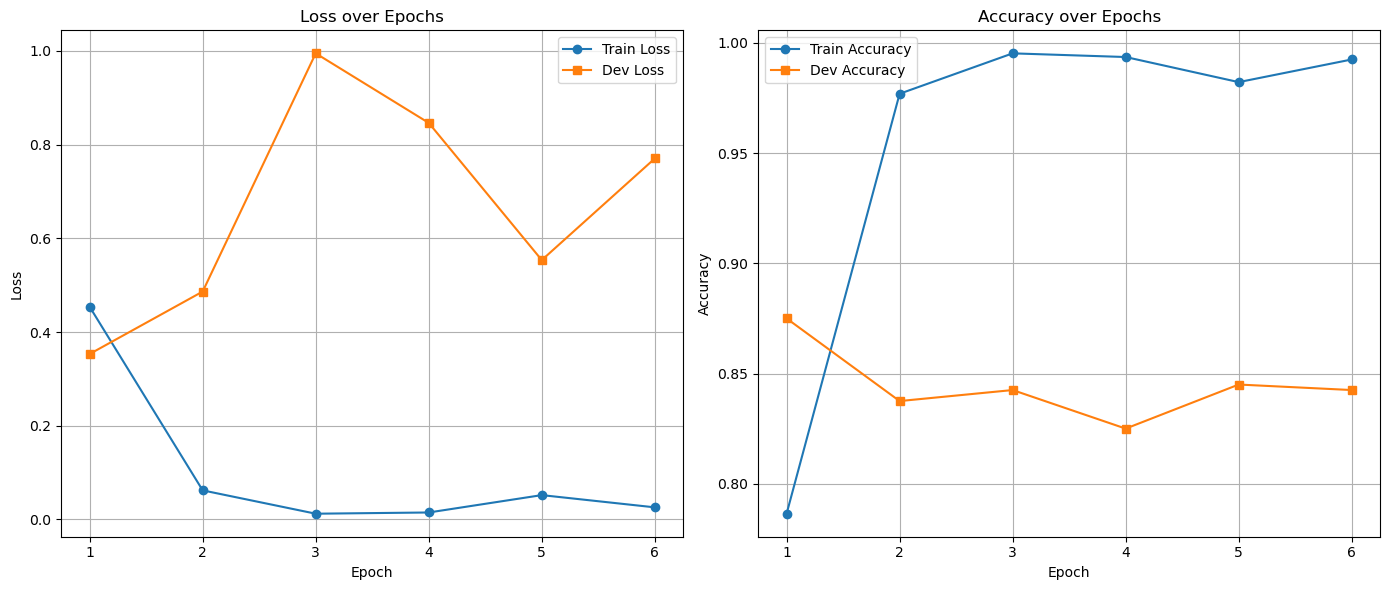

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

num_epochs = 10
batch_size = 16
min_delta = 0.001
patience = 5

train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []

best_dev_accuracy = 0.0
best_model_state = copy.deepcopy(model.state_dict())
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        outputs, _ = model(batch_X)
        loss = criterion(outputs, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == batch_Y).sum().item()
        total_train += batch_Y.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    dev_running_loss, correct_dev, total_dev = 0.0, 0, 0
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs, attn_weights = model(batch_X)
            loss = criterion(outputs, batch_Y)
            dev_running_loss += loss.item() * batch_X.size(0)
            _, preds = torch.max(outputs, 1)
            correct_dev += (preds == batch_Y).sum().item()
            total_dev += batch_Y.size(0)
    epoch_dev_loss = dev_running_loss / len(dev_loader.dataset)
    epoch_dev_acc = correct_dev / total_dev
    dev_losses.append(epoch_dev_loss)
    dev_accuracies.append(epoch_dev_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Dev Loss: {epoch_dev_loss:.4f}, Dev Acc: {epoch_dev_acc:.4f}")

    if epoch_dev_acc > best_dev_accuracy + min_delta:
        best_dev_accuracy = epoch_dev_acc
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)
print(f"\nBest Dev Accuracy: {best_dev_accuracy:.4f}")

model.eval()
test_preds, test_labels = [], []
test_running_loss = 0.0
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        outputs, _ = model(batch_X)
        loss = criterion(outputs, batch_Y)
        test_running_loss += loss.item() * batch_X.size(0)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_Y.cpu().numpy())

test_loss = test_running_loss / len(test_loader.dataset)
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, len(dev_losses) + 1), dev_losses, marker='s', label='Dev Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(dev_accuracies) + 1), dev_accuracies, marker='s', label='Dev Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Token indices: [6638, 10254, 0, 6762, 129]


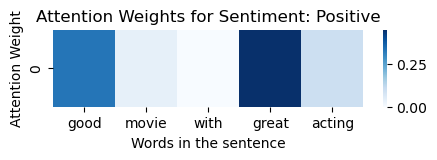

Token indices: [10254, 0, 15631, 129]


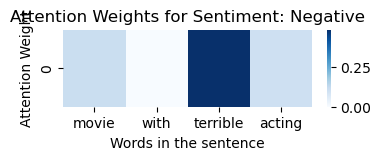

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json

def visualize_attention(sentence, model, vocab, max_length=105, vocab_size=17502):
    words = sentence.split()
    tokens = [vocab.get(word, 0) for word in words]
    print("Token indices:", tokens)

    multi_hot_vector = torch.zeros(vocab_size)
    for index in tokens:
        if index < vocab_size:
            multi_hot_vector[index] = 1
    multi_hot_vector = multi_hot_vector.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output, attn_weights = model(multi_hot_vector)

    sentiment = "Positive" if torch.argmax(output, 1).item() == 1 else "Negative"

    if attn_weights.dim() == 2:
        attn_weights = attn_weights[:, :len(tokens)].cpu().numpy()
    else:
        print("Attention weights shape mismatch:", attn_weights.shape)
        return

    plt.figure(figsize=(len(tokens), 1))
    sns.heatmap(attn_weights, annot=False, cmap="viridis", cbar=True, xticklabels=words)
    plt.title(f"Attention Weights for Sentiment: {sentiment}")
    plt.xlabel("Words in the sentence")
    plt.ylabel("Attention Weight")
    plt.show()

with open("vocab.json", "r") as f:
    vocab = json.load(f)

sentence = "good movie with great acting"
visualize_attention(sentence, model, vocab, max_length=105, vocab_size=17502)

sentence2 = "movie with terrible acting"
visualize_attention(sentence2, model, vocab, max_length=105, vocab_size=17502)


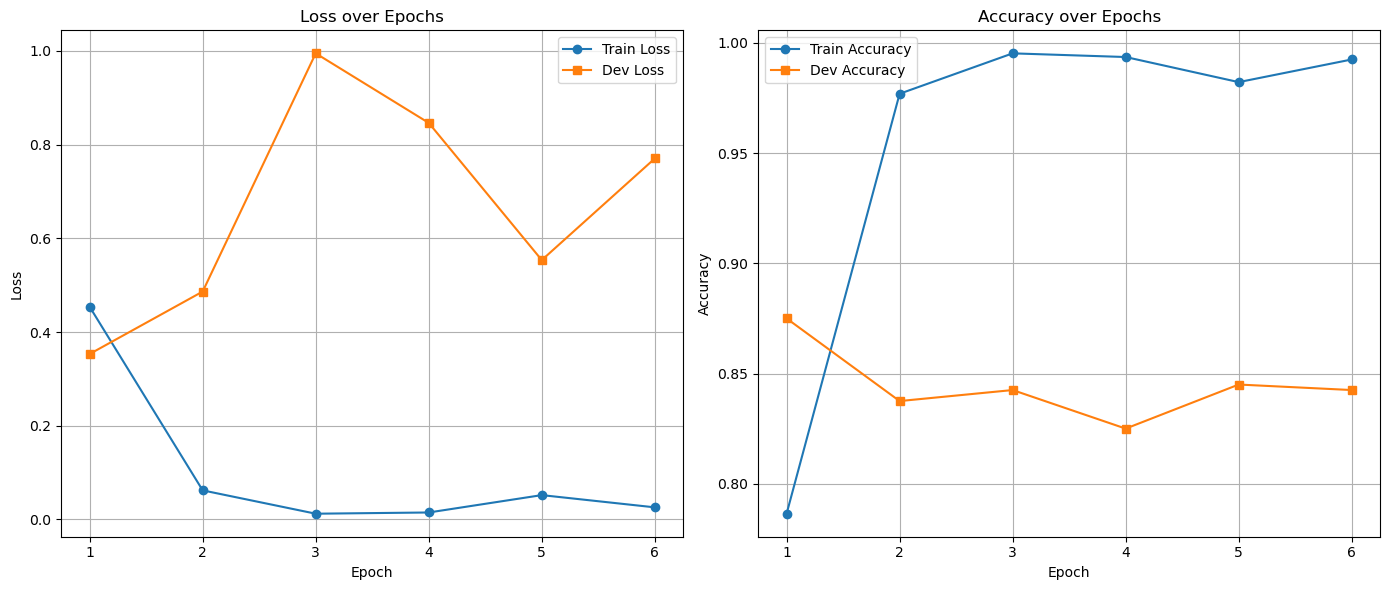

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, len(dev_losses) + 1), dev_losses, marker='s', label='Dev Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(dev_accuracies) + 1), dev_accuracies, marker='s', label='Dev Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


#### End. 